# Benchmarking of Graph Network

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
from moleculekit.molecule import Molecule
from moleculekit.periodictable import periodictable
import numpy as np
import torch as pt
from torch.utils.benchmark import Timer
from torchmdnet.models.model import create_model
from torchmdnet.optimize import optimize as optimize_model

## Models

In [2]:
# Graph network (default)
model_1 = create_model({
    'embedding_dimension': 128,
    'num_layers': 6,
    'num_rbf': 50,
    'rbf_type': 'expnorm',
    'trainable_rbf': True,
    'activation': 'silu',
    'neighbor_embedding': True,
    'cutoff_lower': 0.0,
    'cutoff_upper': 5.0,
    'max_z': 100,
    'max_num_neighbors': 32,
    'model': 'graph-network',
    'aggr': 'add',
    'derivative': False,
    'atom_filter': -1,
    'prior_model': None,
    'output_model': 'Scalar',
    'reduce_op': 'add'
})

# Graph network (compatible with NNPOps, https://github.com/torchmd/torchmd-net/issues/48),
# i.e. rbf_type='gauss', trainable_rbf=False, activation='ssp', and neighbor_embedding=False
model_2 = create_model({
    'embedding_dimension': 128,
    'num_layers': 6,
    'num_rbf': 50,
    'rbf_type': 'gauss',
    'trainable_rbf': False,
    'activation': 'ssp',
    'neighbor_embedding': False,
    'cutoff_lower': 0.0,
    'cutoff_upper': 5.0,
    'max_z': 100,
    'max_num_neighbors': 32,
    'model': 'graph-network',
    'aggr': 'add',
    'derivative': False,
    'atom_filter': -1,
    'prior_model': None,
    'output_model': 'Scalar',
    'reduce_op': 'add'
})

## Benchmarking function

In [3]:
def benchmark(model, pdb_file, device, optimize=True, compute_forces=True, compute_derivatives=False, batch_size=1):

    # Optimize the model
    model = deepcopy(model).to(device)
    if optimize:
        assert not compute_derivatives
        assert batch_size == 1
        model = optimize_model(model)

    # Setup the derivative computation
    for parameter in model.parameters():
        parameter.requires_grad = compute_derivatives

    # Get molecular data
    molecule = Molecule(pdb_file)
    atomic_numbers = pt.tensor([periodictable[symbol].number for symbol in molecule.element], dtype=pt.long, device=device)
    positions = pt.tensor(molecule.coords[:,:,0], dtype=pt.float32, device=device).to(device)

    # Setup a batch
    batch = pt.flatten(pt.tile(pt.arange(batch_size).unsqueeze(1), (1, len(atomic_numbers)))).to(device)
    atomic_numbers = pt.tile(atomic_numbers, (batch_size,))
    positions = pt.tile(positions, (batch_size, 1)).detach()

    # Setup the force computation
    assert not (compute_forces and (batch_size > 1))
    positions.requires_grad = compute_forces

    # Benchmark
    stmt = f'''
        energy = model(atomic_numbers, positions, batch)
        {'energy[0].sum().backward()' if compute_forces or compute_derivatives else ''}
        '''
    timer = Timer(stmt=stmt, globals=locals())
    speed = timer.blocked_autorange(min_run_time=10).median * 1000 # s --> ms

    return speed

## Speed for MD

In [4]:
device = pt.device('cuda')
systems = [('systems/alanine_dipeptide.pdb', 'ALA2'),
           ('systems/chignolin.pdb', 'CLN'),
           ('systems/dhfr.pdb', 'DHFR'),
           ('systems/factorIX.pdb', 'FC9'),
           ('systems/stmv.pdb', 'STMV')]

methods = [('default', model_1, False),
           ('compatible', model_2, False),
           ('optimized', model_2, True)]

speed_methods = {}
for meth, model, optimize in methods:
    speed_methods[meth] = {}
    print(f'Method: {meth}')
    for pdb_file, name in systems:
        try:
            speed = benchmark(model, pdb_file, device, optimize=optimize, compute_forces=True, compute_derivatives=False, batch_size=1)
            speed_methods[meth][name] = speed
            print(f'  {name}: {speed} ms/it')
        except Exception as e:
            print(f'  {name}: failed')

Method: default
  ALA2: 7.852263981476426 ms/it
  CLN: 8.225349669810385 ms/it
  DHFR: 27.21661669202149 ms/it
  FC9: 65.51229511387646 ms/it
  STMV: failed
Method: compatible
  ALA2: 7.383093530079351 ms/it
  CLN: 7.977409199811517 ms/it
  DHFR: 25.64150399994105 ms/it
  FC9: 62.23246781155467 ms/it
  STMV: failed
Method: optimized
  ALA2: 2.734545150306076 ms/it
  CLN: 3.929289639927447 ms/it
  DHFR: 20.75393449049443 ms/it
  FC9: 47.54591805394739 ms/it
  STMV: 217.71628607530147 ms/it


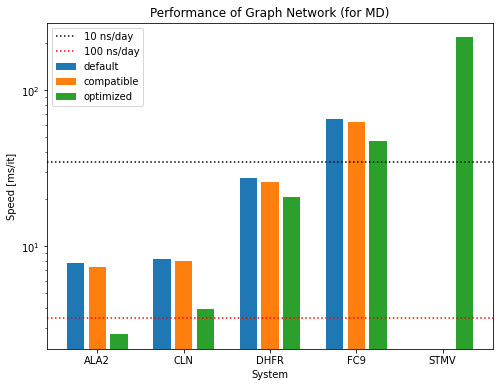

In [5]:
plt.figure(figsize=(8,6))

labels = []
for i, (meth, speeds) in enumerate(speed_methods.items()):
    labels = speeds.keys() if len(speeds.keys()) > len(labels) else labels
    x = np.arange(len(speeds)) + 0.25*i - 0.25
    plt.bar(x, speeds.values(), width=0.2, log=True, label=meth)

plt.axhline(34.56, color='black', linestyle=':', label='10 ns/day')
plt.axhline(3.456, color='red', linestyle=':', label='100 ns/day')

plt.title('Performance of Graph Network (for MD)')
plt.xlabel('System')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Speed [ms/it]')
plt.legend()
plt.show()

## Speed for inference and training

In [6]:
device = pt.device('cuda')
systems = [('systems/alanine_dipeptide.pdb', 'ALA2'),
           ('systems/chignolin.pdb', 'CLN'),
           ('systems/dhfr.pdb', 'DHFR'),
           ('systems/factorIX.pdb', 'FC9'),
           ('systems/stmv.pdb', 'STMV')]

speed_inference = {}
for pdb_file, name in systems:
    speed_inference[name] = {}
    print(f'System: {name}')
    for batch_size in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024):
        try:
            speed = benchmark(model_1, pdb_file, device, optimize=False, compute_forces=False, compute_derivatives=False, batch_size=batch_size)
            speed_inference[name][batch_size] = speed
            print(f'  {batch_size}: {speed} ms/it')
        except Exception as e:
            print(f'  {batch_size}: failed')

System: ALA2
  1: 2.5806247303262353 ms/it
  2: 2.6035668700933456 ms/it
  4: 2.645490919239819 ms/it
  8: 2.7056596404872835 ms/it
  16: 2.7221463806927204 ms/it
  32: 2.7560028596781194 ms/it
  64: 4.2596927110571405 ms/it
  128: 7.2362863924354315 ms/it
  256: 13.14713570754975 ms/it
  512: 24.94113480206579 ms/it
  1024: 48.6939629772678 ms/it
System: CLN
  1: 2.7635874692350626 ms/it
  2: 2.8175582049880172 ms/it
  4: 3.7817843700759113 ms/it
  8: 6.205195549409837 ms/it
  16: 10.87750195292756 ms/it
  32: 20.342897553928196 ms/it
  64: 38.8993666972965 ms/it
  128: 76.25738007482141 ms/it
  256: 152.26690692361444 ms/it
  512: 303.5780100617558 ms/it
  1024: 608.4158178418875 ms/it
System: DHFR
  1: 14.775000151712447 ms/it
  2: 24.597198888659477 ms/it
  4: 44.10969840828329 ms/it
  8: 83.3530118688941 ms/it
  16: 162.49962442088872 ms/it
  32: 322.6637861225754 ms/it
  64: 630.0162250408903 ms/it
  128: failed
  256: failed
  512: failed
  1024: failed
System: FC9
  1: 38.06128

In [7]:
device = pt.device('cuda')
systems = [('systems/alanine_dipeptide.pdb', 'ALA2'),
           ('systems/chignolin.pdb', 'CLN'),
           ('systems/dhfr.pdb', 'DHFR'),
           ('systems/factorIX.pdb', 'FC9'),
           ('systems/stmv.pdb', 'STMV')]

speed_training = {}
for pdb_file, name in systems:
    speed_training[name] = {}
    print(f'System: {name}')
    for batch_size in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024):
        try:
            speed = benchmark(model_1, pdb_file, device, optimize=False, compute_forces=False, compute_derivatives=True, batch_size=batch_size)
            speed_training[name][batch_size] = speed
            print(f'  {batch_size}: {speed} ms/it')
        except Exception as e:
            print(f'  {batch_size}: failed')

System: ALA2
  1: 5.246556689962745 ms/it
  2: 6.43798989476636 ms/it
  4: 6.762395496480167 ms/it
  8: 7.438803277909756 ms/it
  16: 7.241337443701923 ms/it
  32: 10.024334152694792 ms/it
  64: 11.317517946008593 ms/it
  128: 21.076745353639126 ms/it
  256: 36.19976422050968 ms/it
  512: 65.30508247669786 ms/it
  1024: 124.31978504173458 ms/it
System: CLN
  1: 8.889210340566933 ms/it
  2: 9.632434090599418 ms/it
  4: 9.27276280708611 ms/it
  8: 18.307410390116274 ms/it
  16: 30.377877689898014 ms/it
  32: 53.783495584502816 ms/it
  64: 100.32421408686787 ms/it
  128: failed
  256: failed
  512: failed
  1024: failed
System: DHFR
  1: 34.22370969783514 ms/it
  2: 58.593000983819366 ms/it
  4: 105.5183638818562 ms/it
  8: failed
  16: failed
  32: failed
  64: failed
  128: failed
  256: failed
  512: failed
  1024: failed
System: FC9
  1: 75.82235499285161 ms/it
  2: 131.27196510322392 ms/it
  4: failed
  8: failed
  16: failed
  32: failed
  64: failed
  128: failed
  256: failed
  51

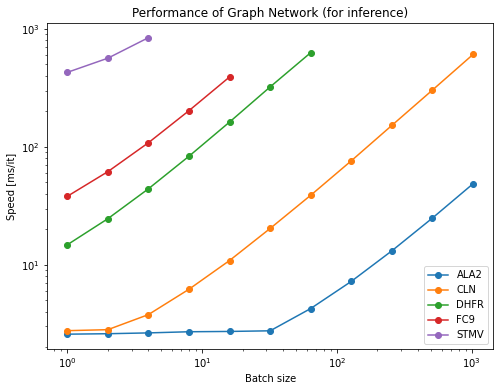

In [8]:
plt.figure(figsize=(8,6))

for name, speeds in speed_inference.items():
    plt.plot(speeds.keys(), speeds.values(), label=name, marker='o')

plt.title('Performance of Graph Network (for inference)')
plt.xlabel('Batch size')
plt.ylabel('Speed [ms/it]')
plt.loglog()
plt.legend()
plt.show()

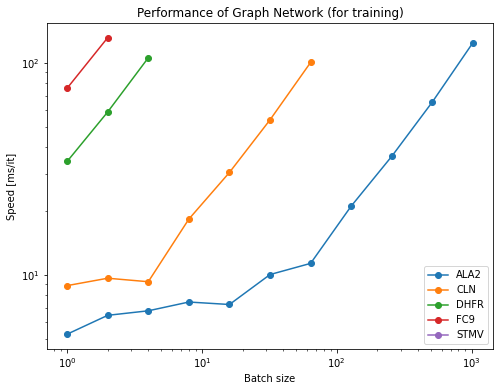

In [9]:
plt.figure(figsize=(8,6))

for name, speeds in speed_training.items():
    plt.plot(speeds.keys(), speeds.values(), label=name, marker='o')

plt.title('Performance of Graph Network (for training)')
plt.xlabel('Batch size')
plt.ylabel('Speed [ms/it]')
plt.loglog()
plt.legend()
plt.show()